In [1]:
# basic
import numpy as np
import pandas as pd

# diagnostics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# models
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# cosmetics
import warnings
warnings.filterwarnings('ignore')

# Data

Preprocessing is in ML_get_data.py

In [2]:
data_raw = pd.read_csv('../data/ML_data_raw.csv')
data_raw['date'] = pd.to_datetime(data_raw['date'])

# remove some features
factor_to_exclude = ['ret_60_12', 'ni_ar1', 'beta_60m'] # too many NAs
data_raw = data_raw[[col for col in data_raw.columns.to_list() if col not in factor_to_exclude]]

# drop remaining NAs
data = data_raw.dropna()
factor_names = data.columns.to_list()[4:]

In [3]:
# y = data['weight']
y = data['weight_diff'] # using weight_diff instead of weight bc weight itself is unpredictable
X = data[factor_names]
for col in X.columns:
    col_mean = X[col].mean()
    col_std = X[col].std()
    X[col] = (X[col] - col_mean) / col_std
    X[col] = X[col].clip(lower=-3, upper=3) # normalize features to [-3,3]

# Split train, val, test
test_time_start = data['date'].max() - pd.DateOffset(years=1) # last 1 years as test
val_time_start = test_time_start - pd.DateOffset(years=1) # 1 years as val
data_test = data[data['date'] >= test_time_start]
data_val = data[(data['date'] >= val_time_start) & (data['date'] < test_time_start)]
data_train = data[data['date'] < val_time_start]
X_test = X[data['date'] >= test_time_start]
X_val = X[(data['date'] >= val_time_start) & (data['date'] < test_time_start)]
X_train = X[data['date'] < val_time_start]
y_test = y[data['date'] >= test_time_start]
y_val = y[(data['date'] >= val_time_start) & (data['date'] < test_time_start)]
y_train = y[data['date'] < val_time_start]

# special train set for time-series cross validation (automanaged by sklearn)
X_train_auto_val = X[data['date'] < test_time_start]
y_train_auto_val = y[data['date'] < test_time_start]

In [4]:
result = pd.DataFrame(index=['RMSE', 'R2'])

# OLS

In [5]:
%%time
# train
model_OLS = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model_OLS_reg_l1 = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Gaussian()).fit_regularized(L1_wt=1, alpha=0.1)
model_OLS_reg_l2 = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Gaussian()).fit_regularized(L1_wt=0, alpha=0.1)

# val
def validation_helper(y_true: pd.Series, y_vals: list):
    result = pd.DataFrame(index=['RMSE', 'R2'])
    for i in range(len(y_vals)):
        rmse = np.sqrt(mean_squared_error(y_true, y_vals[i]))
        r2 = r2_score(y_true, y_vals[i])
        result[f'submodel_{i+1}'] = pd.Series([rmse, r2], index=result.index)
    print(f"{result.loc['RMSE'].idxmin()} has lowest RMSE.")
    print(f"{result.loc['R2'].idxmax()} has highest R2.")
    return result

y_hat_val_OLS = model_OLS.predict(sm.add_constant(X_val))
y_hat_val_OLS_reg_l1 = model_OLS_reg_l1.predict(sm.add_constant(X_val))
y_hat_val_OLS_reg_l2 = model_OLS_reg_l2.predict(sm.add_constant(X_val))
validation_helper(y_val, [y_hat_val_OLS, y_hat_val_OLS_reg_l1, y_hat_val_OLS_reg_l2])

submodel_3 has lowest RMSE.
submodel_3 has highest R2.
CPU times: total: 93.8 ms
Wall time: 148 ms


,submodel_1,submodel_2,submodel_3
RMSE,0.003569,0.003892,0.003546
R2,-0.187236,-0.411477,-0.171687


In [34]:
y_pred = model_OLS_reg_l2.predict(sm.add_constant(X_test)) # using submodel_3 (OLS with l2 reg) based on validation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

result['OLS'] = np.array([rmse, r2])
result

,OLS,XGB
RMSE,0.003160,0.003342
R2,-0.158073,-0.294967


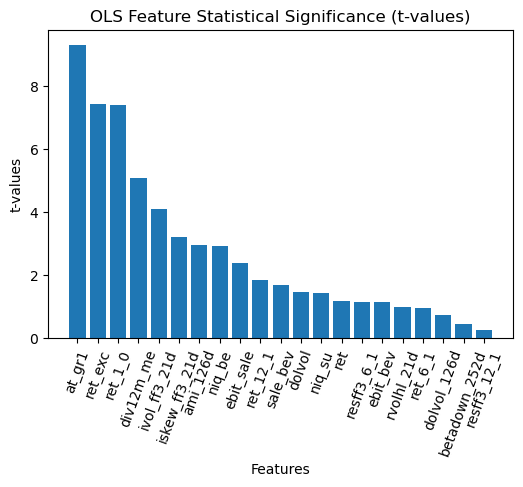

In [64]:
t_vals = model_OLS.tvalues.abs().sort_values(ascending=False)
t_vals = t_vals.iloc[1:] # remove const

plt.figure(figsize=(6, 4))
plt.bar(range(t_vals.shape[0]), t_vals)
plt.xticks(range(t_vals.shape[0]), np.array(t_vals.index), rotation=70)
plt.xlabel('Features')
plt.ylabel('t-values')
plt.title('OLS Feature Statistical Significance (t-values)')
plt.show()

# https://wrds-www.wharton.upenn.edu/data-dictionary/contrib_global_factor/global_factor/
# at_gr1: Asset Growth
# ret_exc: Excess return in USD
# ret_1_0: Short-term reversal
# div12m_me: Dividend yield
# ivol_ff3_21d: Idiosyncratic volatility from the Fama-French 3-factor model
# iskew_ff3_21d: Idiosyncratic skewness from the Fama-French 3-factor model
# niq_be: Quarterly return on equity

# XGB

In [7]:
# %%time
# model = xgb.XGBRegressor(
#     objective='reg:squarederror',  # Objective function for regression
#     random_state=42                # Random seed for reproducibility
# )

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 6, 10],
#     'learning_rate': [0.1, 0.2],
# }

# tscv = TimeSeriesSplit(n_splits=5)
# grid_search = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)
# grid_search.fit(X_train_auto_val, y_train_auto_val)
# print(f"Best parameters: {grid_search.best_params_}")
# best_model = grid_search.best_estimator_
# best_model.save_model('models/XGB.json')

In [60]:
best_model = xgb.XGBRegressor()
best_model.load_model('models/XGB.json')
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

result['XGB'] = np.array([rmse, r2])
result

,OLS,XGB
RMSE,0.003160,0.003342
R2,-0.158073,-0.294967


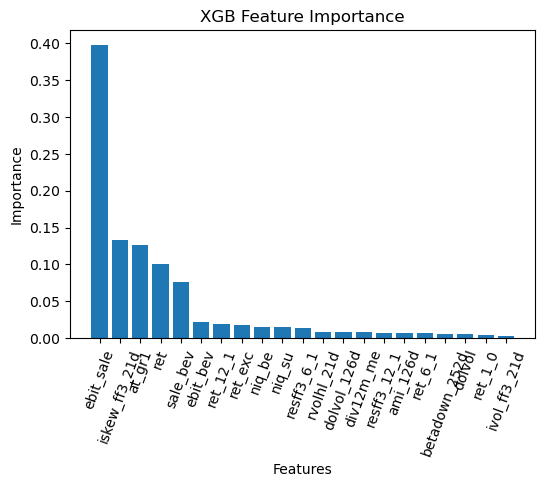

In [66]:
feature_importances_rf = best_model.feature_importances_

# Sort the feature importances in descending order and plot
sorted_idx_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(6, 4))
plt.bar(range(X.shape[1]), feature_importances_rf[sorted_idx_rf])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('XGB Feature Importance')
plt.xticks(range(X.shape[1]), np.array(X.columns)[sorted_idx_rf], rotation=70)
plt.show()

# https://wrds-www.wharton.upenn.edu/data-dictionary/contrib_global_factor/global_factor/
# ebit_sale: Profit margin
# iskew_ff3_21d: Idiosyncratic skewness from the Fama-French 3-factor model
# at_gr1: Asset Growth
# ret: Total return in USD
# sale_bev: Assets turnover

# Model Diagnostic

In [52]:
# best_model = xgb.XGBRegressor()
# best_model.load_model('models/XGB.json')
# y_pred = best_model.predict(X)
best_model = model_OLS_reg_l2
y_pred = best_model.predict(sm.add_constant(X))

In [53]:
diagnostic = pd.DataFrame()
diagnostic['error'] = np.sqrt(np.abs(data['weight_diff'] - y_pred))
diagnostic['date'] = data['date']
diagnostic['permno'] = data['permno']
diagnostic['type'] = diagnostic.apply(lambda row: 'train' if row['date']<test_time_start else 'test', axis=1)
diagnostic

,error,date,permno,type
1495,0.048655,2015-09-30,10026,train
1496,0.014866,2015-09-30,10032,train
1497,0.034929,2015-09-30,10104,train
1498,0.044988,2015-09-30,10107,train
1499,0.012988,2015-09-30,10138,train
...,...,...,...,...
53319,0.070879,2022-09-30,93380,test
53320,0.040819,2022-09-30,93419,test
53322,0.020660,2022-09-30,93427,test
53323,0.026629,2022-09-30,93429,test


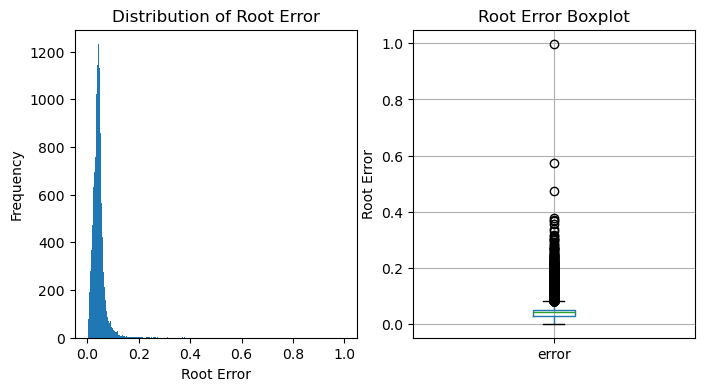

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].hist(diagnostic['error'], bins=1000)
axs[0].set_xlabel('Root Error')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Root Error')

diagnostic.boxplot(column='error', ax=axs[1])
axs[1].set_title('Root Error Boxplot')
axs[1].set_ylabel('Root Error')

plt.show()

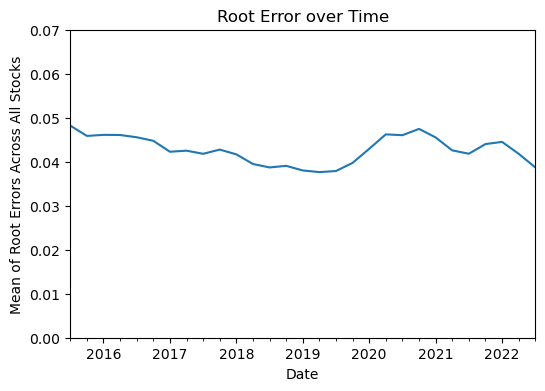

In [70]:
mean_error_over_time = diagnostic.groupby('date')['error'].mean()

mean_error_over_time.plot(figsize=(6, 4))
plt.ylim((0,0.07))
plt.title('Root Error over Time')
plt.xlabel('Date')
plt.ylabel('Mean of Root Errors Across All Stocks')
plt.show()